<a href="https://colab.research.google.com/github/ohalilou/ml-student/blob/main/Land_Cover_Project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#THIS IS THE WORK OF:
##EL ALOUT ISMAIL & HALILOUA OTHMANE
##HPC/BIG DATA

# Land Cover Type Classification with PyTorch

This notebook serves as a starting point for your machine learning project on land cover type classification.

The task at hand involves classifying land cover types, such as 'Forest,' 'River,' 'Highway,' and more, based on satellite images. The dataset consists of images labeled with their corresponding land cover types. The goal is to train a machine learning model that can accurately predict the land cover type of new, unseen images.

In this notebook, you'll find code snippets to load and visualize the data, providing insights into the images and their labels.

## Build Your Model

You have the freedom to choose the architecture or model for your land cover classification task. Whether you opt for a simple convolutional neural network (CNN) or explore transfer learning with pre-trained models, the notebook provides a flexible starting point. Experiment with different architectures to achieve the best performance.

## Model Training and Evaluation

Once your model is defined, the notebook guides you through the process of training it on the dataset. Additionally, it includes code to evaluate the model's performance on the validation and test sets.

Feel free to modify, experiment, and enhance the provided code. Happy coding !

Please submit your weekly assignments to me via [email](mailto:elmontassir@cerfacs.fr) to receive your score on the test set.



# Data Extraction

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tarfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models

In [2]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [3]:
# Loading the dataset
!wget -nv https://cerfacs.fr/opendata/cours/data/TRAIN.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/TEST.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/y_train.npy

2023-12-28 18:44:00 URL:https://cerfacs.fr/opendata/cours/data/TRAIN.tar [44851200/44851200] -> "TRAIN.tar" [1]
2023-12-28 18:44:03 URL:https://cerfacs.fr/opendata/cours/data/TEST.tar [15687680/15687680] -> "TEST.tar" [1]
2023-12-28 18:44:05 URL:https://cerfacs.fr/opendata/cours/data/y_train.npy [1600128/1600128] -> "y_train.npy" [1]


In [4]:
# Using tarfile to create np arrays
def extract_files(dataset):
    tar = tarfile.open(dataset+'.tar', 'r')
    names = tar.getmembers()[:]
    images = [tar.extractfile(name) for name in names]
    return np.array([np.array(Image.open(image)) for image in images])

In [5]:
X_train = extract_files('TRAIN')
X_test = extract_files('TEST')
y_train = np.load('y_train.npy').reshape(-1, 1)
print("Train data : ",X_train.shape)
print("Train labels", y_train.shape)
print("Test data : ",X_test.shape)

Train data :  (20000, 64, 64, 3)
Train labels (20000, 1)
Test data :  (7000, 64, 64, 3)


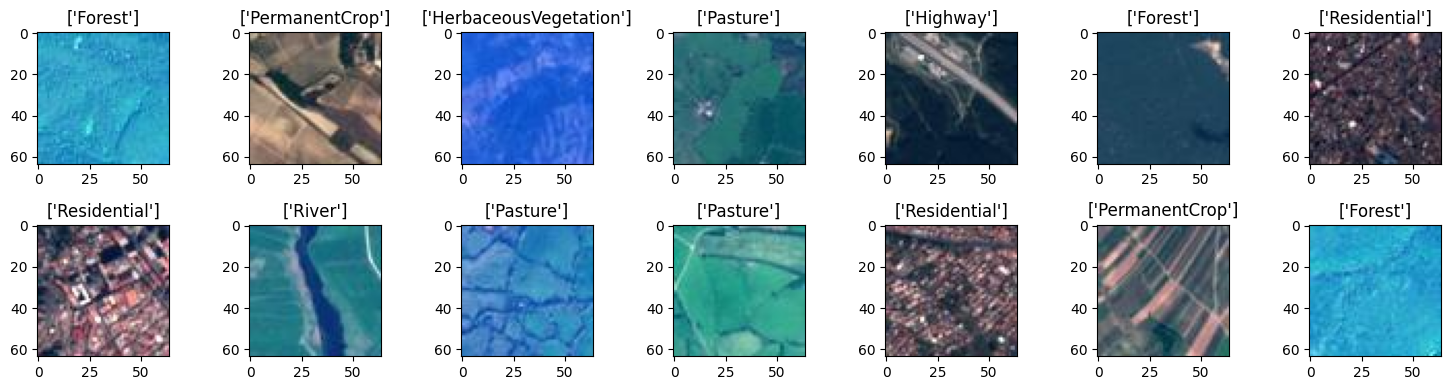

In [6]:
# Display data samples
fig, axes = plt.subplots(2, 7, figsize=(15, 4))
axes = axes.ravel()
for i in range(14):
    axes[i].imshow(X_train[i])
    axes[i].set_title(y_train[i])
plt.tight_layout()

There are 10 possible classes for each image (only one per image is correct):

  - 'AnnualCrop'
  - 'Forest'
  - 'HerbaceousVegetation'
  - 'Highway'
  - 'Industrial'
  - 'Pasture'
  - 'PermanentCrop'
  - 'Residential'
  - 'River'
  - 'SeaLake'

We could simply code an integer value for each: 'AnnualCrop' = 0, 'Forest' = 1, etc... This is known as "Ordinal Encoding", and has some drawbacks, e.g. if the network is unsure whether it is class 0 or 2, it could end up saying 1, which is another class altogether. When categories have a natural order, ordinal encoding can be a good way to go. Here, this is not the case.

The most classical way to convert the type of labels here to numeric values is through [**one-hot encoding**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features). In this process, the label is converted to a vector with length the number of possible labels, and only the one matching the true label is set to 1, all others are set to 0.

|                 | Type1 | Type2 | Type3 |   | Label Vector |
|-----------------|:-----:|:-----:|:-----:|---|:------------:|
| Sample1: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample2: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample3: Type 1 |   1   |   0   |   0   |   |   [1, 0, 0]  |
| ...             |       |       |       |   |              |

Scikit-learn has a useful class for this, [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), which does this automatically. More importantly, it remembers the encoding, and you can use it again after making your final predictions te *decode* them back to text labels, as expected by the competition.

In [7]:
# Convert labels to one-hot encoding
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()

# The Data Preparation

Note: the images here are encoded with 8-bit integers, *i.e.* between 0 and 255. A normalization is needed.

In [8]:
# Prepare data for training
X_train, X_test = X_train/255, X_test/255
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
print(mean)
print(std)
X_train, X_test = 255*X_train, X_test*255

[0.29088279 0.41201959 0.48920503]
[0.2240432  0.17601508 0.21699366]


In [9]:
# Assuming X_train and y_train are PyTorch tensors
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Data augmentation
transform_augmentation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

X_train_tensor = torch.stack([transform_augmentation(img.astype('uint8')) for img in X_train]).float()
X_valid_tensor = torch.stack([transform_augmentation(img.astype('uint8')) for img in X_valid]).float()
X_test_tensor = torch.stack([transform_augmentation(img.astype('uint8')) for img in X_test]).float()

y_train_tensor = torch.from_numpy(y_train)
y_valid_tensor = torch.from_numpy(y_valid)

The normalization coefficients for the mean and standard deviation are commonly used for image data normalization within the range of [0, 255] or [0, 1]. This process brings pixel values into a standard range centered around zero, facilitating the acceleration of neural network training. In this case, we begin by dividing by 255 to scale values to [0, 1]. Subsequently, subtracting the mean centers the range around zero, and dividing by the standard deviation reduces the range to a centered Gaussian distribution, promoting stability.

Normalization coefficients may vary depending on the dataset, image characteristics, and network architecture. Experimenting with different strategies is common in model development. For specific datasets, calculating the mean and standard deviation directly from the training data can provide a good normalization.

#The model

In [10]:
# Define the Model

class ModelPerso(nn.Module):
  def __init__(self):
    super(ModelPerso, self).__init__()
    self.resnet = models.resnet50(pretrained=True)
    self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

  def forward(self, x):
    x = self.resnet(x)
    return x


##Some auxiliary functions

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plotting functions
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [12]:
from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset


train_set = TensorDataset(X_train_tensor, torch.Tensor(y_train))
val_set = TensorDataset(X_valid_tensor, torch.Tensor(y_valid))
test_set = TensorDataset(X_test_tensor)

# Create the dataloaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Training with k-fold cross-validation:

In [13]:
torch.manual_seed(42)  # Set a fixed seed

criterion = nn.CrossEntropyLoss()
batch_size = 64

num_folds = 5
num_epochs = 20
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

folds_accs = {}

training_loss = {}
training_accuracy = {}

validation_loss = {}
validation_accuracy = {}

for fold, (train_index, val_index) in enumerate(kf.split(ConcatDataset([train_set, val_set]))):
    print(f'\nFold {fold + 1}/{num_folds}')

    # Create data loaders for the current fold
    train_loader = DataLoader(ConcatDataset([train_set, val_set]), batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_index))
    val_loader = DataLoader(ConcatDataset([train_set, val_set]), batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(val_index))

    model = ModelPerso().to(device)
    learning_rate = 0.0001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001, amsgrad=True)


    patience = 7  # Number of epochs to wait for improvement
    early_stopping_counter = 0
    best_valid_loss = np.Inf
    best_valid_accuracy = 0
    training_loss[fold] = []
    training_accuracy[fold] = []
    validation_loss[fold] = []
    validation_accuracy[fold] = []
    for epoch in range(num_epochs):
        train_loss = 0
        correct_t = 0
        total_t = 0
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _,predicted = outputs.max(1)
            total_t += labels.size(0)
            correct_t += predicted.eq(torch.argmax(labels,1)).sum().item()

        train_acc = correct_t/total_t
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss / len(train_loader):.3f}, Accuracy: {100*train_acc:.2f}%')
        training_loss[fold].append(train_loss)
        training_accuracy[fold].append(train_acc)

        # saving the model
        # save_path = f'./model-fold-{fold}.pth'
        # torch.save(model.state_dict(), save_path)

        all_predictions = []
        all_labels = []
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(torch.argmax(labels,1)).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {valid_loss / len(val_loader):.3f}, Accuracy: {100*accuracy:.2f}%')
        # folds_accs[fold] = accuracy
        validation_loss[fold].append(valid_loss)
        validation_accuracy[fold].append(accuracy)

        # Early stopping callback
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            early_stopping_counter = 0  # Reset counter
            print("remise à 0 du counter \n")
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f'Early stopping after {epoch + 1} epochs without improvement.')
            if accuracy > best_valid_accuracy:
              best_valid_accuracy = accuracy
              # Save the best model based on the best validation accuracy
              best_model_state = model.state_dict()
              folds_accs[fold] = accuracy
            break
        if accuracy > best_valid_accuracy:
            best_valid_accuracy = accuracy
            # Save the best model based on the best validation accuracy
            best_model_state = model.state_dict()
            folds_accs[fold] = accuracy

    save_path = f'./best_model_fold_{fold}.pth'
    torch.save(best_model_state, save_path)
    folds_accs[fold] = best_valid_accuracy
    print(f"Saved best model for fold {fold} with accuracy {100*best_valid_accuracy:.2f}%")

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {num_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in folds_accs.items():
  print(f'Fold {key+1}: {100*value} %')
  sum += value
print(f'Average: {100*sum/len(folds_accs.items())} %')


Fold 1/5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]


Epoch 1/20, Training Loss: 0.443, Accuracy: 85.54%
Epoch 1/20, Validation Loss: 0.185, Accuracy: 93.58%
remise à 0 du counter 

Epoch 2/20, Training Loss: 0.122, Accuracy: 95.93%
Epoch 2/20, Validation Loss: 0.207, Accuracy: 93.53%
Epoch 3/20, Training Loss: 0.077, Accuracy: 97.52%
Epoch 3/20, Validation Loss: 0.178, Accuracy: 94.38%
remise à 0 du counter 

Epoch 4/20, Training Loss: 0.055, Accuracy: 98.17%
Epoch 4/20, Validation Loss: 0.192, Accuracy: 94.03%
Epoch 5/20, Training Loss: 0.039, Accuracy: 98.67%
Epoch 5/20, Validation Loss: 0.213, Accuracy: 94.73%
Epoch 6/20, Training Loss: 0.040, Accuracy: 98.64%
Epoch 6/20, Validation Loss: 0.178, Accuracy: 94.85%
remise à 0 du counter 

Epoch 7/20, Training Loss: 0.030, Accuracy: 99.00%
Epoch 7/20, Validation Loss: 0.185, Accuracy: 94.50%
Epoch 8/20, Training Loss: 0.029, Accuracy: 99.09%
Epoch 8/20, Validation Loss: 0.195, Accuracy: 94.42%
Epoch 9/20, Training Loss: 0.029, Accuracy: 99.09%
Epoch 9/20, Validation Loss: 0.183, Accuracy:

In [14]:
#the max accu is at fold 1 then we load model from the first fold
model_path = '/content/best_model_fold_0.pth'

state_dict = torch.load(model_path)

# Create an instance of your model
# Replace 'YourModelClass' with the actual class of your model
model_fold = ModelPerso()

# Load the state_dict into the model
model_fold.load_state_dict(state_dict)

# Set the model to evaluation mode
model_fold.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ModelPerso(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

##Evaluation

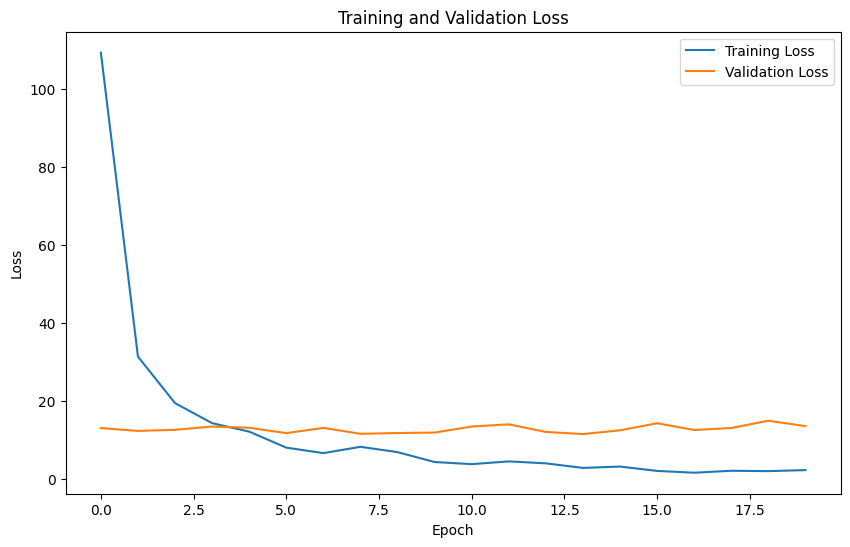

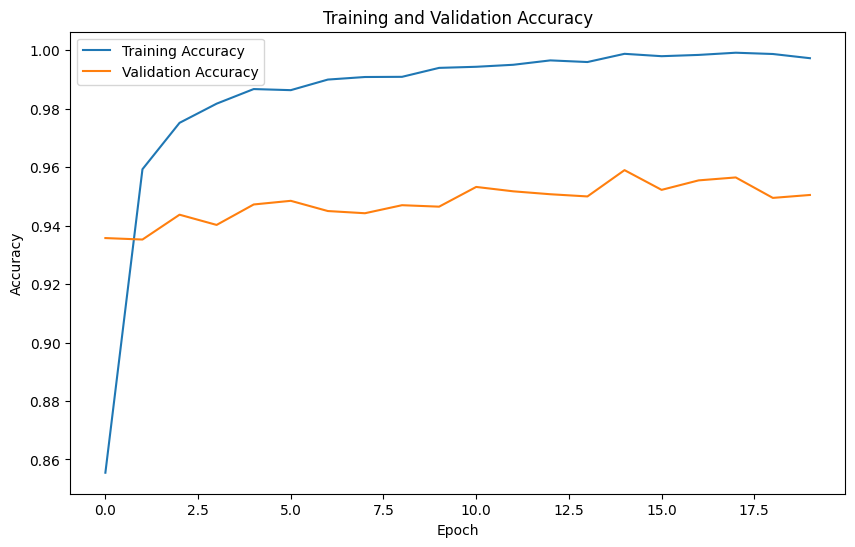

In [15]:
plot_loss(training_loss[4], validation_loss[4]) # replace with mean over folds
plot_accuracy(training_accuracy[0], validation_accuracy[0])

In [16]:
mean_training_loss = [np.mean([training_loss[fold][epoch] for fold in training_loss]) for epoch in range(min(len(training_loss[f]) for f in range(num_folds)))]
mean_validation_loss = [np.mean([validation_loss[fold][epoch] for fold in validation_loss]) for epoch in range(min(len(training_loss[f]) for f in range(num_folds)))]
mean_training_accuracy = [np.mean([training_accuracy[fold][epoch] for fold in training_accuracy]) for epoch in range(min(len(training_accuracy[f]) for f in range(num_folds)))]
mean_validation_accuracy = [np.mean([validation_accuracy[fold][epoch] for fold in validation_accuracy]) for epoch in range(min(len(training_accuracy[f]) for f in range(num_folds)))]

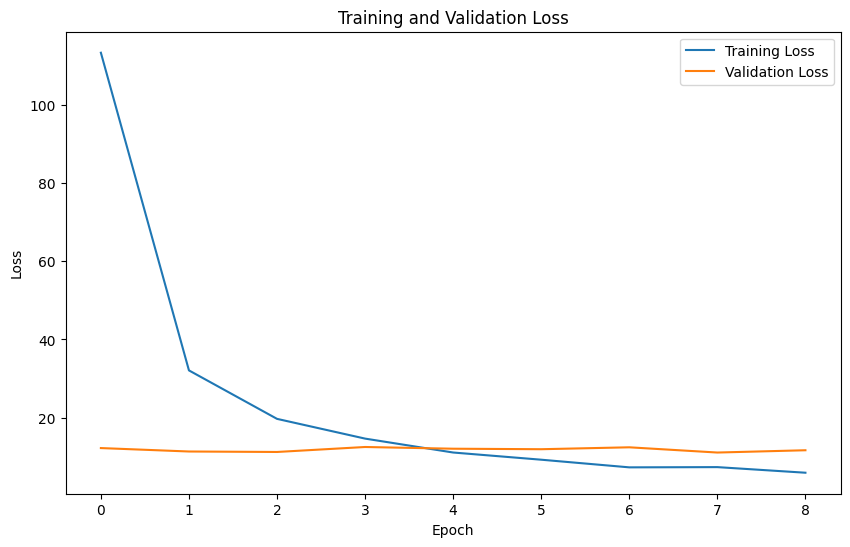

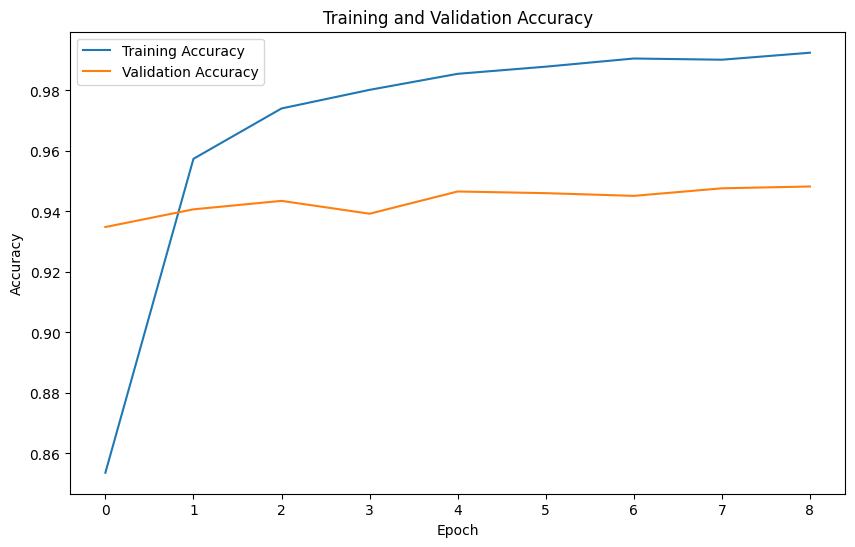

In [17]:
plot_loss(mean_training_loss,mean_validation_loss)
plot_accuracy(mean_training_accuracy, mean_validation_accuracy)

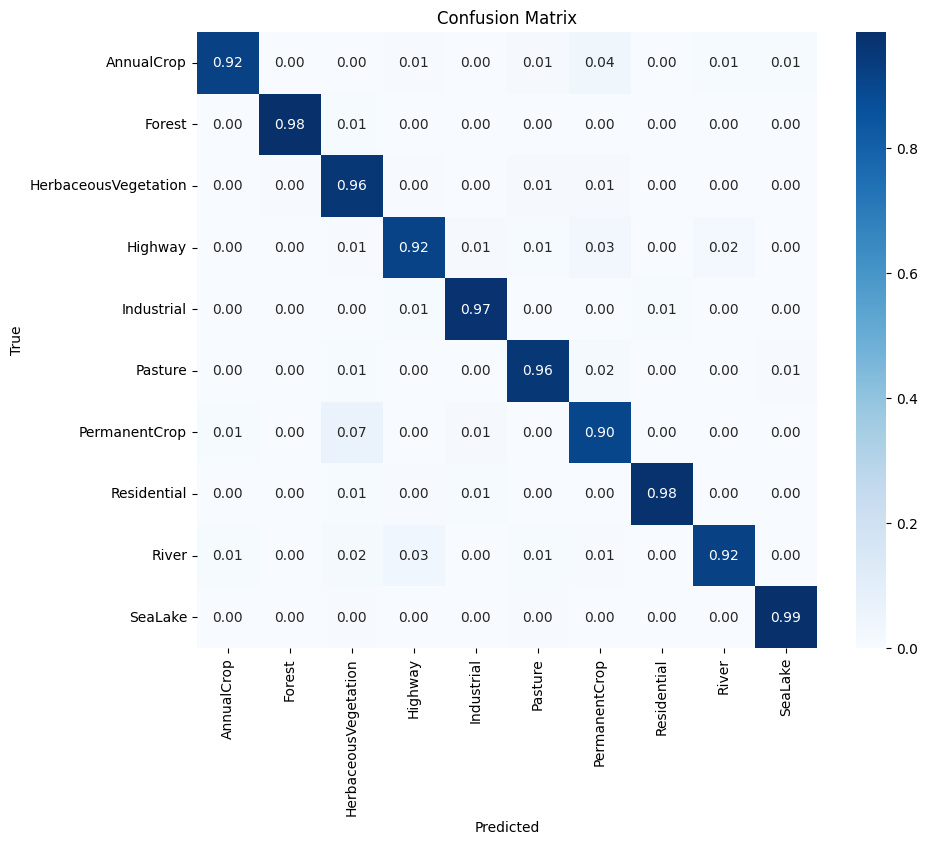

In [18]:
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# print(all_predictions)
# print(np.argmax(all_labels, axis=1))
class_names = encoder.categories_[0]
plot_confusion_matrix(np.argmax(all_labels, axis=1), all_predictions, class_names)

In [19]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(np.argmax(all_labels, axis=1), all_predictions, average='weighted')
print(f'Recall : {recall:.2f}')
print(f'Precision : {precision:.2f}')
print(f'fscore : {fscore:.2f}')

Recall : 0.95
Precision : 0.95
fscore : 0.95


In [20]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(np.argmax(all_labels, axis=1), all_predictions, average=None)

for class_label, prec, rec, f1, sup in zip(range(10), precision, recall, fscore, support):
    print(f'Class {class_label}: Precision={prec:.2f}, Recall={rec:.2f}, F1 Score={f1:.2f}, Support={sup}')


Class 0: Precision=0.98, Recall=0.92, F1 Score=0.95, Support=423
Class 1: Precision=0.99, Recall=0.98, F1 Score=0.99, Support=448
Class 2: Precision=0.91, Recall=0.96, F1 Score=0.93, Support=472
Class 3: Precision=0.93, Recall=0.92, F1 Score=0.92, Support=389
Class 4: Precision=0.96, Recall=0.97, F1 Score=0.96, Support=362
Class 5: Precision=0.92, Recall=0.96, F1 Score=0.94, Support=284
Class 6: Precision=0.88, Recall=0.90, F1 Score=0.89, Support=369
Class 7: Precision=0.99, Recall=0.98, F1 Score=0.98, Support=444
Class 8: Precision=0.96, Recall=0.92, F1 Score=0.94, Support=374
Class 9: Precision=0.98, Recall=0.99, F1 Score=0.99, Support=435


##Testing

In [45]:
# One-hot vector for AnnualCrop: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# One-hot vector for Forest: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
# One-hot vector for HerbaceousVegetation: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
# One-hot vector for Highway: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
# One-hot vector for Industrial: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
# One-hot vector for Pasture: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
# One-hot vector for PermanentCrop: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
# One-hot vector for Residential: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
# One-hot vector for River: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
# One-hot vector for SeaLake: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
l = ['AnnualCrop',
    'Forest',
    'HerbaceousVegetation',
    'Highway',
    'Industrial',
    'Pasture',
    'PermanentCrop',
    'Residential',
    'River',
    'SeaLake']


def lab_hot(num):
  for i in range(10):
    if i ==num:
      return l[i]

In [46]:
model_fold = model_fold.to(device)
X_test_tensor = X_test_tensor.to(device)
# Make predictions on the test data
with torch.no_grad():
    outputs = model(X_test_tensor)

In [47]:
_, predicted_classes = torch.max(outputs, 1)
predicted_classes

tensor([5, 4, 6,  ..., 6, 5, 8], device='cuda:0')

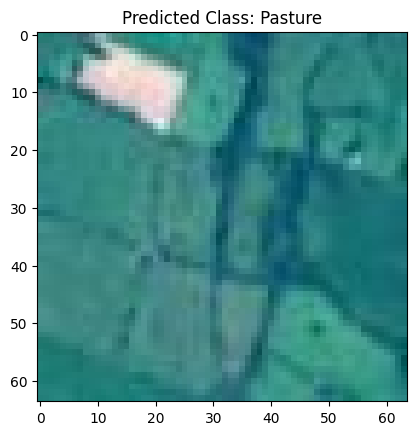

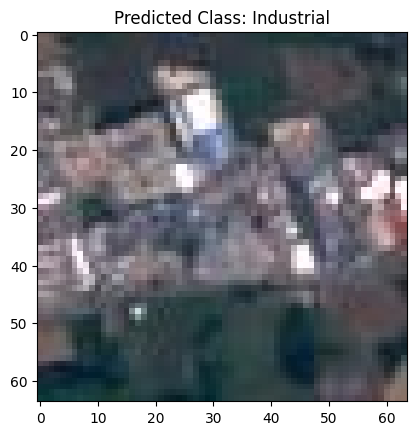

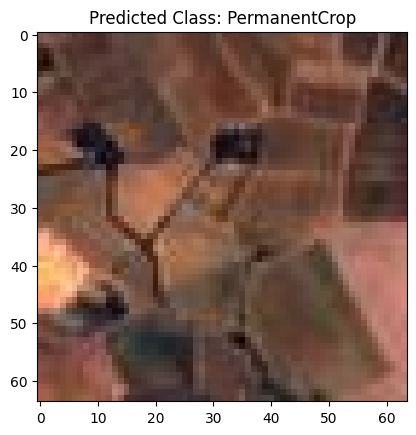

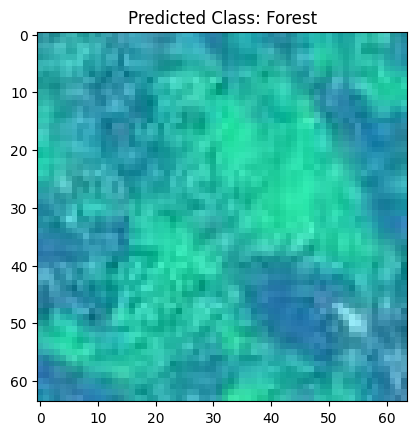

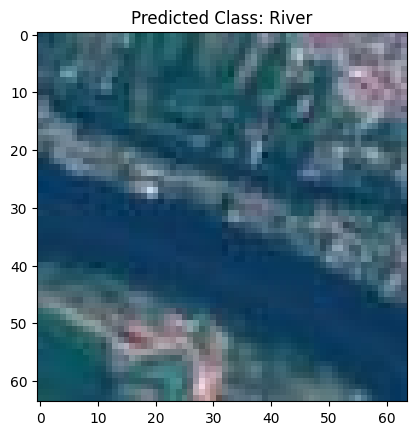

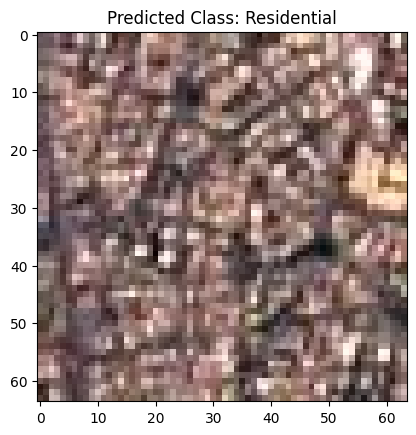

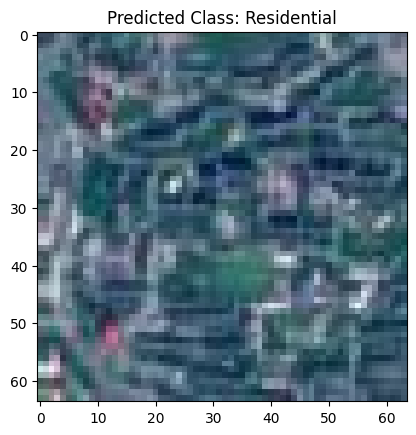

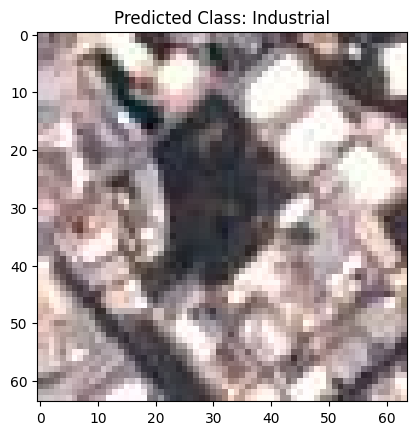

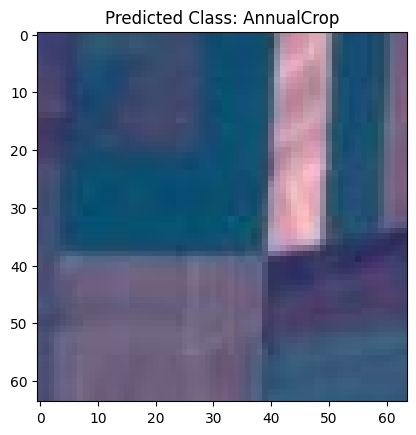

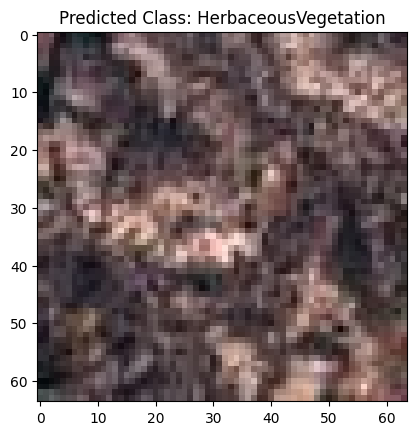

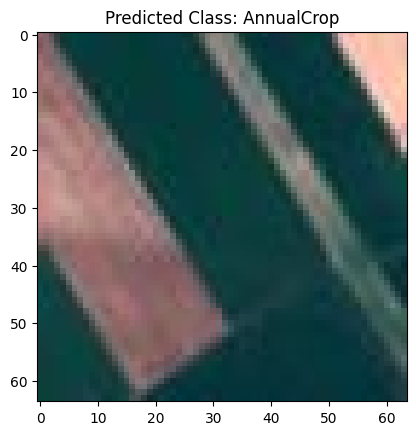

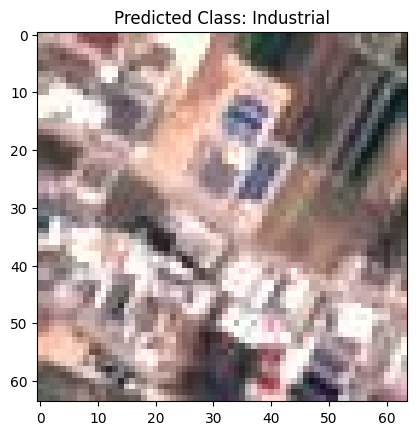

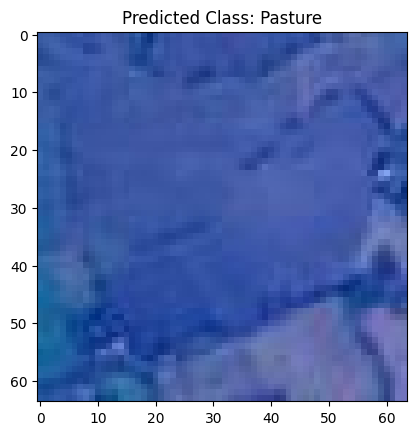

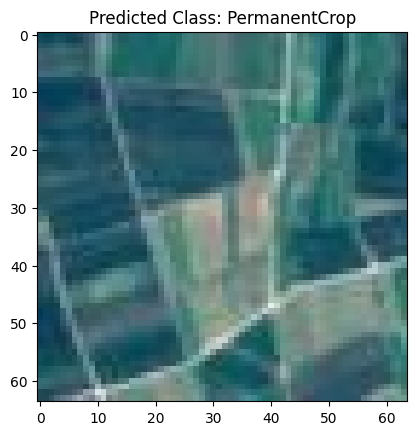

In [49]:
X_test_test = extract_files('TEST')
for i in range(14):
    plt.imshow(X_test_test[i])
    plt.title(f"Predicted Class: {lab_hot(predicted_classes[i])}")
    plt.show()

#Max Accuracy training:

In [27]:
train_set = TensorDataset(X_train_tensor, torch.Tensor(y_train))
val_set = TensorDataset(X_valid_tensor, torch.Tensor(y_valid))
test_set = TensorDataset(X_test_tensor)

# Create the dataloaders
train_loader = DataLoader(train_set, batch_size=50, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=50, shuffle=True)
test_loader = DataLoader(test_set, batch_size=50, shuffle=False)


# train_set = TensorDataset(X_train_tensor, torch.Tensor(y_train))
# val_set = TensorDataset(X_valid_tensor, torch.Tensor(y_valid))
# test_set = TensorDataset(X_test_tensor)

# # Create the dataloaders
# train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

##Defining The Model
After each epoch we check if the new model reaches a new maximum for accuracy, if it does we save the model and use it as a starting point for the next epoch.

In [30]:
model_max = ModelPerso().to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_max.parameters(), lr=0.0001, weight_decay=0.0001, amsgrad=True)

num_epochs = 7

##Training The Model

In [31]:
import copy

max_val_acc_ep = 0
epoch_max = -1
accs = []
losses = []

accs_tr = []
losses_tr = []
best_model = ModelPerso().to(device)

for epoch in range(num_epochs):

    ##########################################TRAINING###############################################################
    model_max.train()
    print(f'Epoch {epoch}/{num_epochs}:')
    print("==>Training:")
    print('||')
    correct_tr = 0
    accuracy_tr = 0
    loss_tr = 0
    total_tr = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_max(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss = criterion(outputs, labels)
        loss_tr += loss.item()
        _, predicted = outputs.max(1)
        total_tr += labels.size(0)
        correct_tr += predicted.eq(torch.argmax(labels,1)).sum().item()
    accuracy_tr = correct_tr / total_tr
    loss_tr = loss_tr / len(train_loader)
    accs_tr.append(accuracy_tr)
    losses_tr.append(loss_tr)
    print(f'=====> Training Loss: {loss_tr:.3f}, Training Accuracy: {100*accuracy_tr:.2f}%')


    ########################################validation###############################################################
    model_max.eval()
    print("==>Validation:")
    print('||')
    with torch.no_grad():
        valid_loss = 0.0
        correct = 0
        total = 0
        all_labels2 = []
        all_predictions2 = []
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_max(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels,1)).sum().item()
            all_predictions2.extend(predicted.cpu().numpy())
            all_labels2.extend(labels.cpu().numpy())
    accuracy = correct / total
    val_loss = valid_loss / len(valid_loader)
    print(f'=====> Validation Loss: {val_loss:.3f}, Validation Accuracy: {100*accuracy:.2f}%')
    accs.append(accuracy)
    losses.append(val_loss)

    #############################CHOOSING the MAX ACCURACY MODEL######################################################
    # At the end of each epoch, save the best model:
    if accuracy > max_val_acc_ep or epoch == 0:
      epoch_max = epoch
      max_val_acc_ep = accuracy
      best_model_wts = copy.deepcopy(model_max.state_dict())
      # After training, before testing the model, load the best model:
      best_model.load_state_dict(best_model_wts)
      model_max.load_state_dict(best_model_wts)
      print(f">>>>>>>  Siezed the model with the maximum validation accuracy at epoch {epoch}, with accuracy = {100*max_val_acc_ep:.2f}%")

print(f"TRAINING FINISHED, model siezed at epoch {epoch_max}/{num_epochs} with accuracy {100*max_val_acc_ep:.2f}.")

Epoch 0/7:
==>Training:
||
=====> Training Loss: 0.448, Training Accuracy: 85.79%
==>Validation:
||
=====> Validation Loss: 0.215, Validation Accuracy: 93.20%
>>>>>>>  Siezed the model with the maximum validation accuracy at epoch 0, with accuracy = 93.20%
Epoch 1/7:
==>Training:
||
=====> Training Loss: 0.144, Training Accuracy: 95.16%
==>Validation:
||
=====> Validation Loss: 0.189, Validation Accuracy: 93.92%
>>>>>>>  Siezed the model with the maximum validation accuracy at epoch 1, with accuracy = 93.92%
Epoch 2/7:
==>Training:
||
=====> Training Loss: 0.098, Training Accuracy: 96.74%
==>Validation:
||
=====> Validation Loss: 0.189, Validation Accuracy: 93.95%
>>>>>>>  Siezed the model with the maximum validation accuracy at epoch 2, with accuracy = 93.95%
Epoch 3/7:
==>Training:
||
=====> Training Loss: 0.064, Training Accuracy: 97.95%
==>Validation:
||
=====> Validation Loss: 0.193, Validation Accuracy: 94.23%
>>>>>>>  Siezed the model with the maximum validation accuracy at epoc

In [32]:
save_path = f'./best_model_max_acc_training.pth'
torch.save(best_model, save_path)

##Ploting Training and validation accuracies and losses:

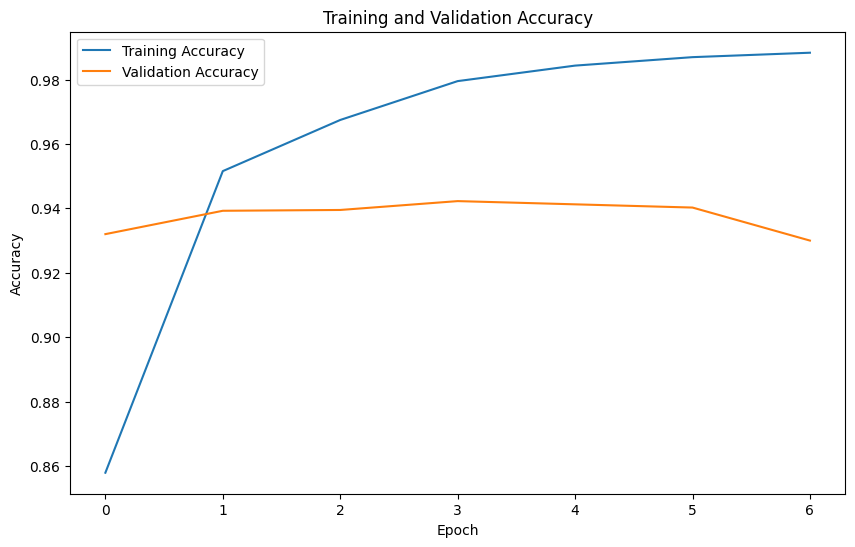

In [33]:
plot_accuracy(accs_tr, accs)

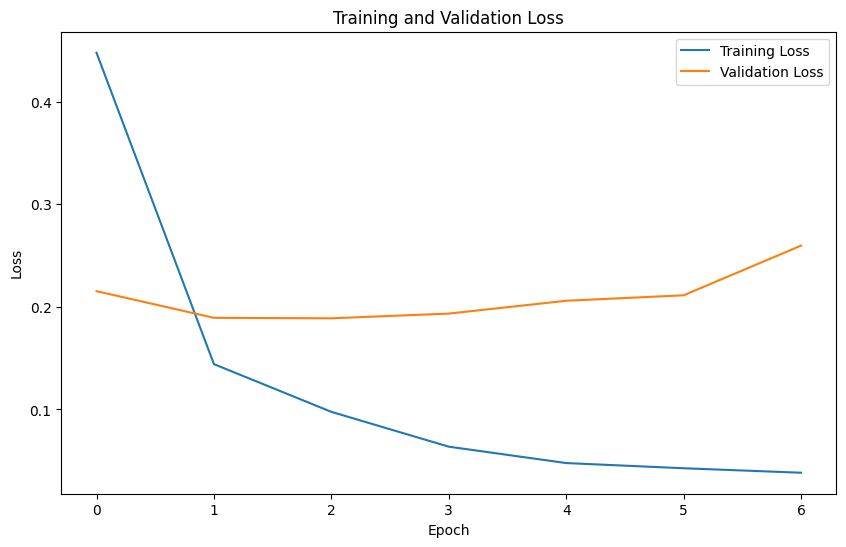

In [34]:
plot_loss(losses_tr,losses)

##The confusion Matrix

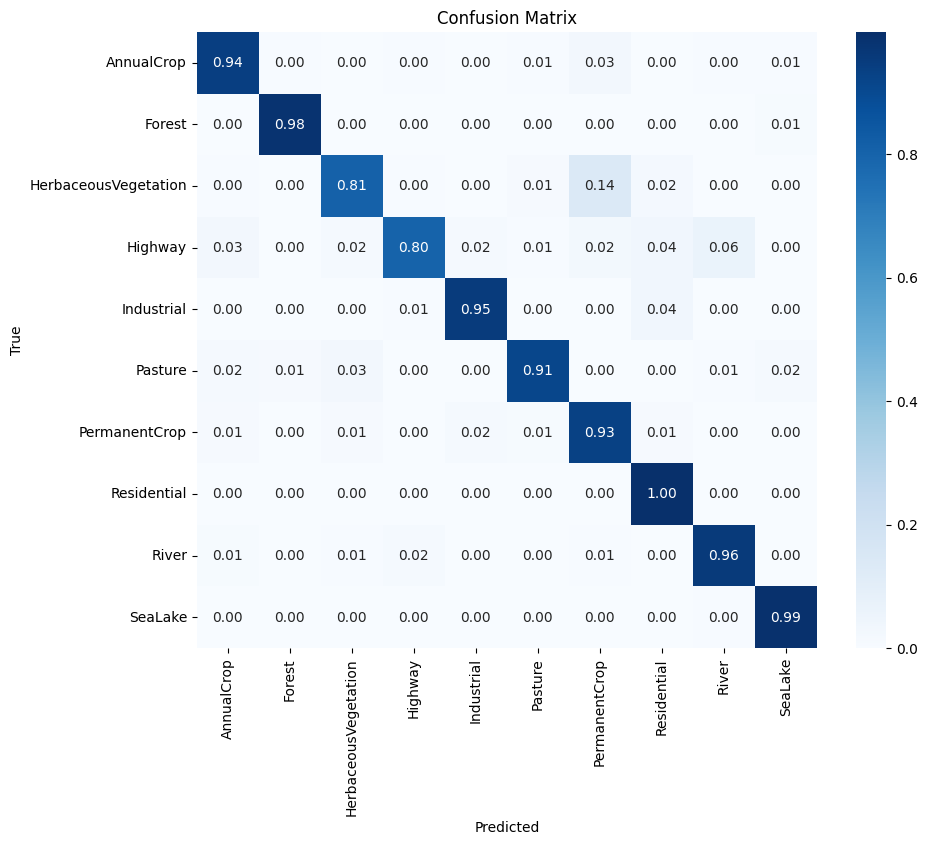

In [35]:
all_predictions2 = np.array(all_predictions2)
all_labels2 = np.array(all_labels2)

class_names = encoder.categories_[0]
plot_confusion_matrix(np.argmax(all_labels2, axis=1), all_predictions2, class_names)

##Other Metrics:

In [36]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(np.argmax(all_labels2, axis=1), all_predictions2, average='weighted')
print(f'Recall : {recall:.2f}')
print(f'Precision : {precision:.2f}')
print(f'fscore : {fscore:.2f}')

Recall : 0.93
Precision : 0.93
fscore : 0.93


In [37]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(np.argmax(all_labels2, axis=1), all_predictions2, average=None)

for class_label, prec, rec, f1, sup in zip(range(10), precision, recall, fscore, support):
    print(f'Class {class_label}: Precision={prec:.2f}, Recall={rec:.2f}, F1 Score={f1:.2f}, Support={sup}')


Class 0: Precision=0.94, Recall=0.94, F1 Score=0.94, Support=445
Class 1: Precision=0.98, Recall=0.98, F1 Score=0.98, Support=443
Class 2: Precision=0.94, Recall=0.81, F1 Score=0.87, Support=453
Class 3: Precision=0.95, Recall=0.80, F1 Score=0.87, Support=370
Class 4: Precision=0.96, Recall=0.95, F1 Score=0.96, Support=370
Class 5: Precision=0.94, Recall=0.91, F1 Score=0.93, Support=301
Class 6: Precision=0.79, Recall=0.93, F1 Score=0.86, Support=370
Class 7: Precision=0.92, Recall=1.00, F1 Score=0.95, Support=445
Class 8: Precision=0.91, Recall=0.96, F1 Score=0.93, Support=362
Class 9: Precision=0.97, Recall=0.99, F1 Score=0.98, Support=441


##Testing:

In [50]:
best_model.eval()
X_test_tensor = X_test_tensor.to(device)
# Make predictions on the test data
with torch.no_grad():
    outputs2 = best_model(X_test_tensor)

In [51]:
_, predicted_classes2 = torch.max(outputs2, 1)
predicted_classes2

tensor([5, 4, 6,  ..., 0, 5, 8], device='cuda:0')

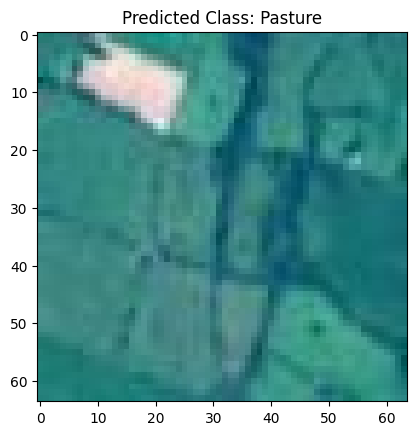

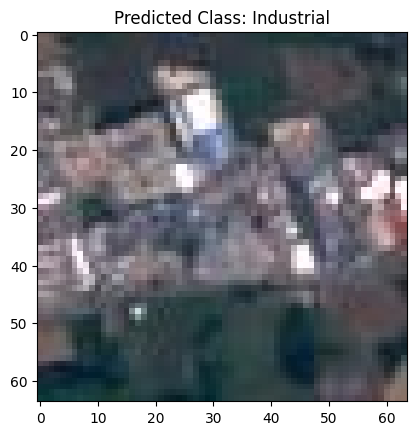

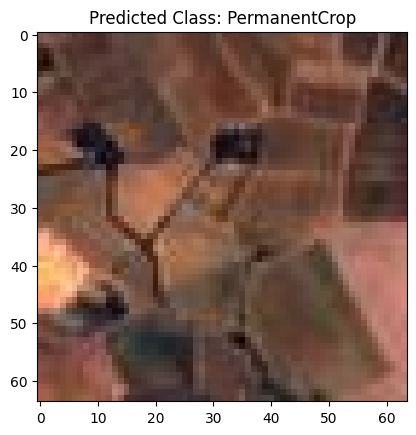

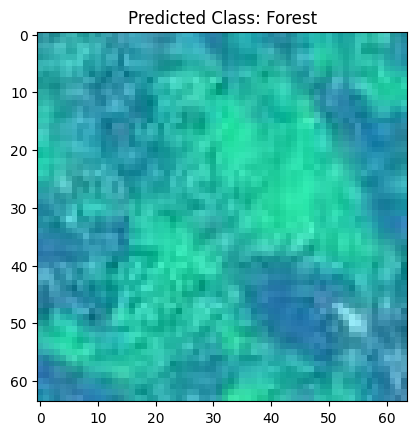

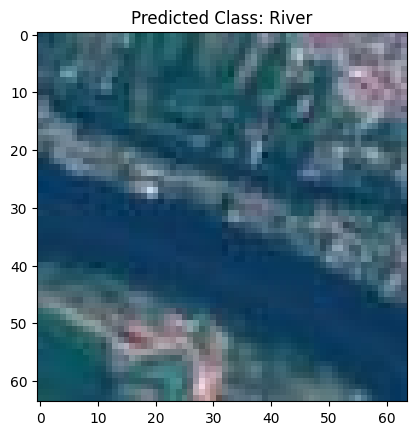

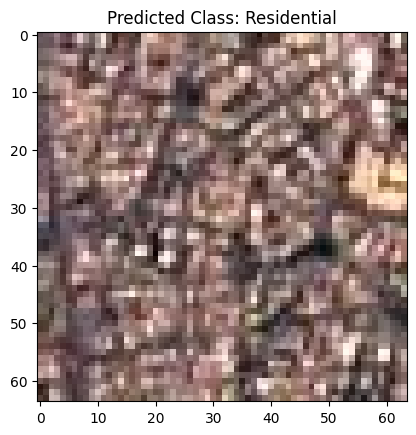

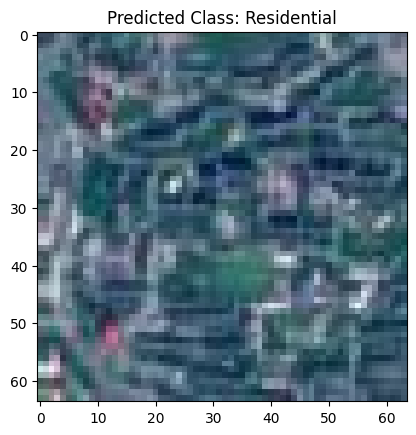

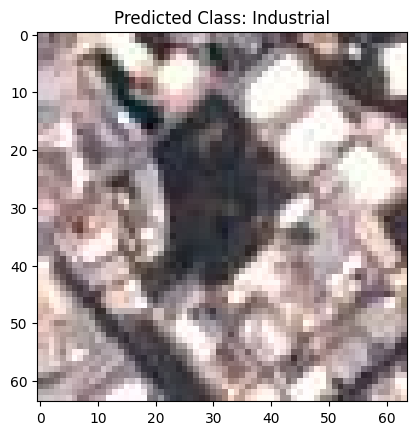

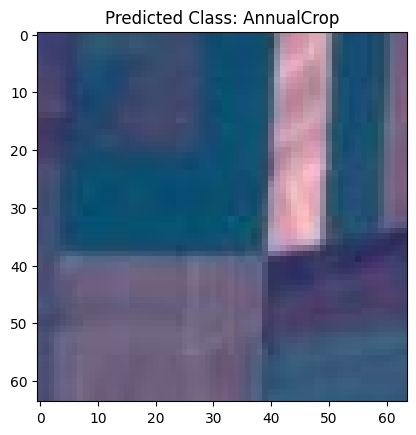

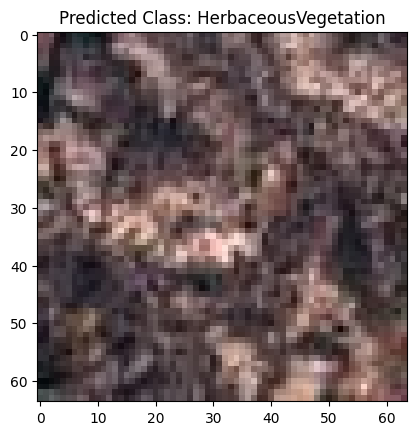

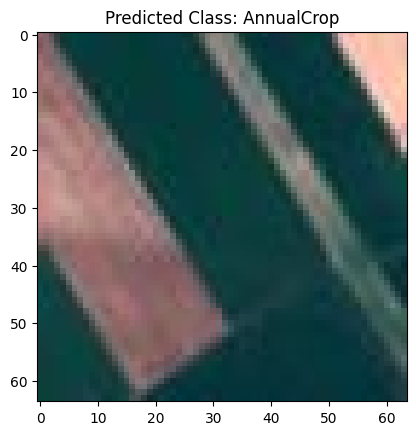

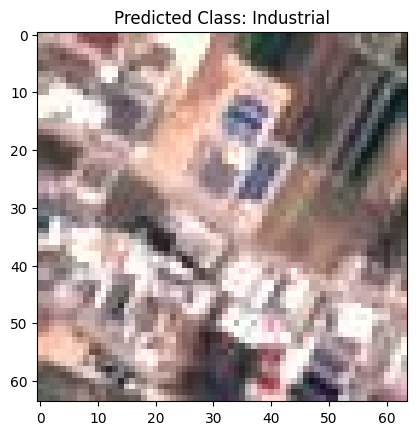

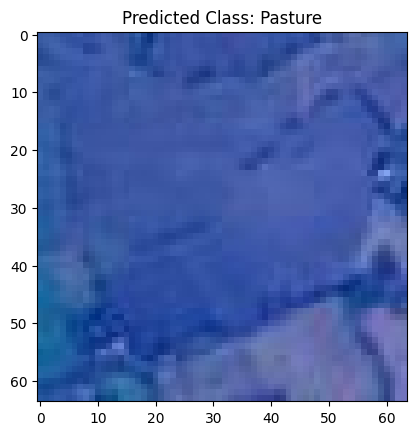

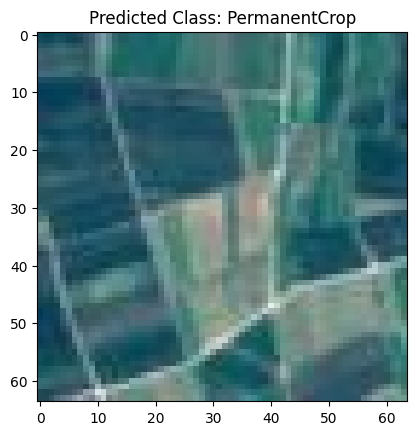

In [55]:
X_test_test = extract_files('TEST')
for i in range(14):
    plt.imshow(X_test_test[i])
    plt.title(f"Predicted Class: {lab_hot(predicted_classes2[i])}")
    plt.show()

# One-hot vector for AnnualCrop: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# One-hot vector for Forest: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
# One-hot vector for HerbaceousVegetation: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
# One-hot vector for Highway: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
# One-hot vector for Industrial: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
# One-hot vector for Pasture: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
# One-hot vector for PermanentCrop: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
# One-hot vector for Residential: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
# One-hot vector for River: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
# One-hot vector for SeaLake: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

#Choice of the model:
The best model was in the first fold of the cross validation training process as ir reached an accuracy of 95.93%, whereas the model from the max accuracy training reached just 95.12% of accuracy.

In [56]:
chosen_model_path = '/content/best_model_fold_0.pth'

state_dict_chosen = torch.load(chosen_model_path)

# Create an instance of your model
# Replace 'YourModelClass' with the actual class of your model
model_chosen = ModelPerso()

# Load the state_dict into the model
model_chosen.load_state_dict(state_dict_chosen)

<All keys matched successfully>

# Create Your Submission

In [62]:
# Function to create a submission file
def create_submission(filename,predictions):
    assert predictions.shape == (7000, 1), f"Wrong shape for your prediction file : {predictions.shape} instead of (7000, 1)"
    with open(f'{filename}.npy', 'wb') as f:
      np.save(f, predictions)
    print("File predictions.npy created !")

In [63]:
device

device(type='cuda')

In [64]:
model_chosen = model_chosen.to(device)
X_test = extract_files('TEST')
X_test = X_test/255
X_test_tensor = torch.stack([transform_augmentation(img.astype('uint8')) for img in X_test]).float()

In [66]:
# Use the following code in the submission cell of your project notebook
# Generate predictions
bs = 35
predictions = np.ones((X_test_tensor.shape[0],10))
for i in range(X_test_tensor.shape[0]//bs):
  predictions[bs*i:bs*(i+1),:] = model_chosen(X_test_tensor[bs*i:bs*(i+1)].to(device)).cpu().detach().numpy()
print(predictions[:5])

# Get labels
predictions = encoder.inverse_transform(predictions)
print(predictions[:5])

# Create a submission using the provided function
NAME = "Haliloua_et_El_Alout"
from datetime import datetime
# Get the current date
current_date = datetime.now()
# Format the date as MM_DD_YY
formatted_date = current_date.strftime("%m_%d_%y")

create_submission(f"{NAME}_{formatted_date}",predictions)



[[-0.59135437 -0.32095173 -1.71781969 -1.58524728 -1.63602257  1.85108638
  -2.4254477  -1.17182398 -0.62346292  1.006302  ]
 [-6.8513093  -0.61268359 -1.94765234  1.13376617  0.42329547 -4.1966095
  -6.15455294 10.11319828 -0.32315984 -5.65733528]
 [ 9.32183933 -0.439917   -1.94901907 -0.34363773 -4.74674797 -1.48439276
   0.90331364 -6.21911144 -3.87015581 -5.32697296]
 [-0.7076053   1.04005146  0.11424298 -1.48438156 -2.84593582 -0.48431441
  -2.07996058 -2.76087213 -0.07753567  1.51331234]
 [-0.7076053   1.04005146  0.11424298 -1.48438156 -2.84593582 -0.48431441
  -2.07996058 -2.76087213 -0.07753567  1.51331234]]
[['Pasture']
 ['Residential']
 ['AnnualCrop']
 ['SeaLake']
 ['SeaLake']]
File predictions.npy created !
